In [1]:
from google.colab import files
uploaded = files.upload()

Saving train-00000-of-00001-c08a401c53fe5312.parquet to train-00000-of-00001-c08a401c53fe5312.parquet


In [2]:
import pandas as pd
import io

train_df = pd.read_parquet('train-00000-of-00001-c08a401c53fe5312.parquet')

In [3]:
uploaded = files.upload()

Saving test-00000-of-00001-44110b9df98c5585.parquet to test-00000-of-00001-44110b9df98c5585.parquet


In [4]:
test_df = pd.read_parquet('test-00000-of-00001-44110b9df98c5585.parquet')

In [37]:
print(train_df.columns)
print(len(train_df['image']))
print(len(train_df['label']))


Index(['image', 'label'], dtype='object')
5120
5120


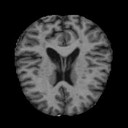

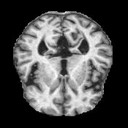

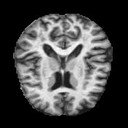

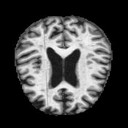

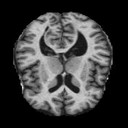

In [38]:
from PIL import Image
import io

for i in range(5):
  image_data = train_df['image'][i]
  image_bytes = image_data['bytes']
  image = Image.open(io.BytesIO(image_bytes))
  display(image)


In [39]:
X_train = train_df['image'].apply(lambda x: x['bytes'])
y_train = train_df['label']

X_test = test_df['image'].apply(lambda x: x['bytes'])
y_test = test_df['label']

In [40]:
import numpy as np
import io

def preprocess_image(image_bytes):
    try:
        image = Image.open(io.BytesIO(image_bytes)).convert("L") #convert to gray-scale
        image = image.resize((128, 128))
        image = np.array(image, dtype=np.float32) / 255.0
        return image
    except Exception as e:
        print("Errore nel caricamento di un'immagine:", e)
        return None


image_bytes_train = train_df['image'].apply(lambda x: x['bytes'])
image_bytes_test = test_df['image'].apply(lambda x: x['bytes'])



X_train = [preprocess_image(b) for b in image_bytes_train]
X_test = [preprocess_image(b) for b in image_bytes_test]


X_train = np.array([img for img in X_train if img is not None])
X_test = np.array([img for img in X_test if img is not None])


X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)



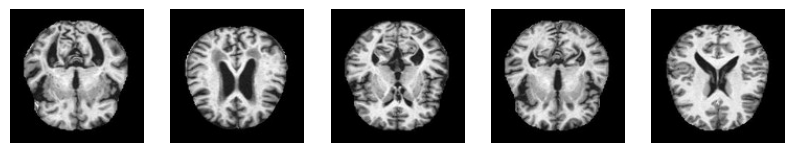

In [41]:
import matplotlib.pyplot as plt
import random


random_indices = random.sample(range(len(X_train)), 5)
random_images = X_train[random_indices]

plt.figure(figsize=(10, 5))
for i, image in enumerate(random_images):
  plt.subplot(1, 5, i + 1)
  plt.imshow(image, cmap="gray")
  plt.axis('off')
plt.show()



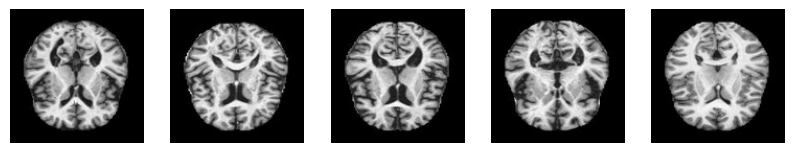

In [42]:
import matplotlib.pyplot as plt
import random


random_indices = random.sample(range(len(X_test)), 5)
random_images = X_train[random_indices]


plt.figure(figsize=(10, 5))
for i, image in enumerate(random_images):
  plt.subplot(1, 5, i + 1)
  plt.imshow(image, cmap="gray")
  plt.axis('off')
plt.show()



In [43]:
print("Forma di X_train:", X_train.shape)
print("Tipo di dati di X_train:", X_train.dtype)

print("Forma di X_test:", X_test.shape)
print("Tipo di dati di X_test:", X_test.dtype)

print(len(train_df['image']))
print(len(train_df['label']))


Forma di X_train: (5120, 128, 128, 1)
Tipo di dati di X_train: float32
Forma di X_test: (1280, 128, 128, 1)
Tipo di dati di X_test: float32
5120
5120


In [44]:


y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)


In [45]:
print(len(train_df['image']))
print(len(train_df['label']))


from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

5120
5120


In [46]:
assert len(X_train) == len(y_train), f"Mismatch: X_train ha {len(X_train)}, y_train ha {len(y_train)}"
assert len(X_test) == len(y_test), f"Mismatch: X_test ha {len(X_test)}, y_test ha {len(y_test)}"
#per vedere se len(y_train)=len(x_train)

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#modello
model = keras.Sequential([
    keras.Input(shape=(128, 128, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])



model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(X_train)

#per evitare overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#addestramento
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.4405 - loss: 1.3153 - val_accuracy: 0.4953 - val_loss: 1.0244
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.5190 - loss: 1.0450 - val_accuracy: 0.5180 - val_loss: 0.9601
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5548 - loss: 0.9537 - val_accuracy: 0.5891 - val_loss: 0.9095
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5640 - loss: 0.9217 - val_accuracy: 0.5492 - val_loss: 0.9031
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5663 - loss: 0.9293 - val_accuracy: 0.5773 - val_loss: 0.9045
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5626 - loss: 0.9318 - val_accuracy: 0.5867 - val_loss: 0.8872
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5943 - loss: 0.8742 - val_accuracy: 0.5977 - val_loss: 0.8684
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5975 - loss: 0.8854 - val_accuracy: 0.

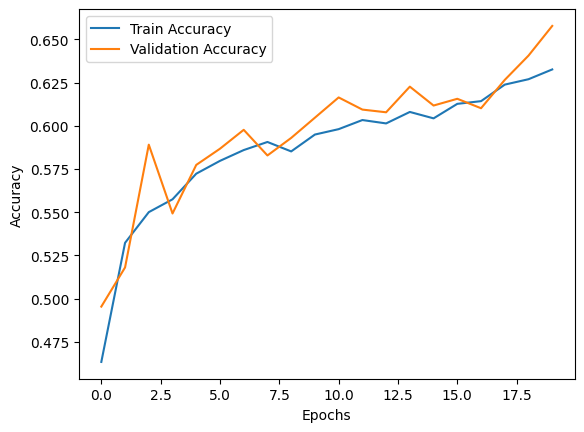

In [50]:
import matplotlib.pyplot as plt

# Traccia il grafico dell'accuratezza
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
